In [1]:
import pandas as pd
import numpy as np
import os
import csv
import gzip
import sys
import datetime
import ast
import matplotlib.pyplot as plt

In [2]:
df_raw = pd.read_csv('../data/raw_survey/processed.csv')
df_score_perinfo = pd.read_csv('../results/scores/survey_scores_perinfo.csv')

## only masking behaviours have multiple choices, indoors no

In [3]:
behaviours_col = ['ResponseId','mask_march2020', 'mask_spring2020',
       'mask_summer2020', 'mask_fall2020', 'mask_winter2020',
       'indoor_march2020', 'indoor_spring2020', 'indoor_summer2020',
       'indoor_fall2020', 'indoor_winter2020']
df_behaviours = df_raw[behaviours_col]

In [4]:
other_col = ['ResponseId','MODZCTA','modzcta_count']
df = df_score_perinfo[other_col].merge(df_behaviours, on='ResponseId',how='left')

In [5]:
def replace_phrases_with_numbers(cell_value,my_dict):
    # Split the cell value by comma and strip whitespace from each phrase
    phrases = [phrase.strip() for phrase in cell_value.split(",")]
    # Look up each phrase in the replacement_dict and collect the numbers
    numbers = [my_dict.get(phrase) for phrase in phrases if phrase in my_dict]
    return numbers

### as it is a list of numbers, we need to convert it to a single number
def calculate_average(numbers_list):
    if not numbers_list:  # In case the list is empty
        return 0
    return sum(numbers_list) / len(numbers_list)

def determine_color(row):
    # Extract the first and last elements
    first_element = row[0]
    last_element = row[-1]
    
    # Check if all elements are equal
    if all(x == row[0] for x in row):
        return 'green'  # All elements are equal
    # Check if the last element is larger than the first
    elif last_element > first_element:
        return 'blue'
    # Check if the last element is smaller than the first
    elif last_element < first_element:
        return 'red'
    # If the first and last elements are equal but not all elements are equal
    else:
        return 'orange'

In [6]:
df['mask_spring2020'].unique()

array(['I always wore it when I left home',
       'I never left home in this period', 'Indoors',
       'When places were crowded', 'Only in places that forced it',
       'I never wore a mask when I left home',
       'When most people were masking',
       'When most people were masking,When places were crowded',
       'When most people were masking,Indoors,When places were crowded',
       'Only in places that forced it,When most people were masking',
       'When most people were masking,Indoors',
       'Indoors,When places were crowded',
       'Only in places that forced it,When most people were masking,When places were crowded',
       'Only in places that forced it,When places were crowded',
       'Only in places that forced it,Indoors',
       'Only in places that forced it,Indoors,When places were crowded',
       'Only in places that forced it,When most people were masking,Indoors,When places were crowded',
       'Only in places that forced it,When most people were mask

In [7]:
replacement_dict_mask = {
    "I never left home in this period": 0,
    "I never wore a mask when I left home": 6,
    "Only in places that forced it": 5,
    "When most people were masking": 4,
    "Indoors": 3,
    "When places were crowded": 2,
    "I always wore it when I left home": 1
}

In [8]:
mask_cols = ['mask_march2020',
       'mask_spring2020', 'mask_summer2020', 'mask_fall2020',
       'mask_winter2020']
mask_cols_num = [f"{column}_num" for column  in mask_cols]
for column in mask_cols:
    new_col_name = f"{column}_num"  # Creates a new column name by appending '_num' to the original column name
    df[new_col_name] = df[column].apply(lambda x: replace_phrases_with_numbers(x, replacement_dict_mask))

# Apply the function to each cell in the selected columns and create a new column for the averages
for column in mask_cols:
    new_col_name = f"{column}_num" 
    df[new_col_name + '_avg'] = df[new_col_name].apply(calculate_average)

df['mask_averages'] = df[[col + '_num_avg' for col in mask_cols]].values.tolist()

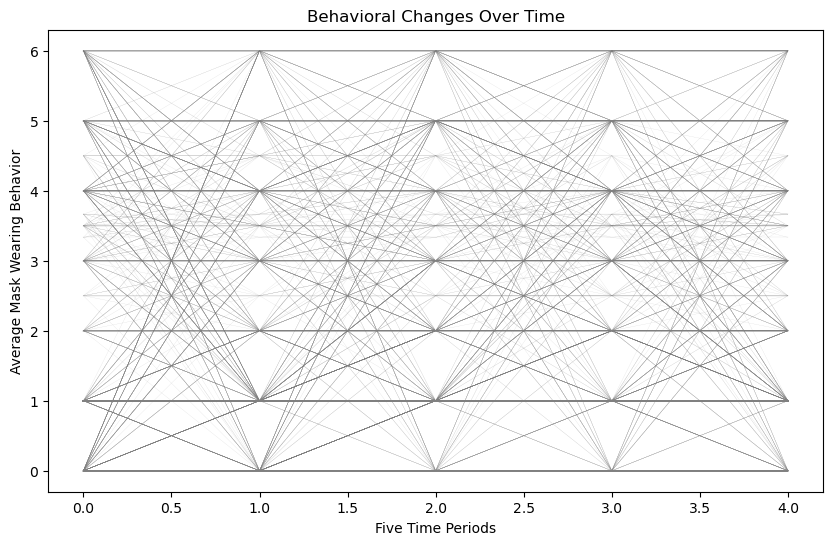

In [9]:
plt.figure(figsize=(10, 6))

# For each row in the dataframe, plot the 5 elements as a line
for index, row in df.iterrows():
    plt.plot(row['mask_averages'], linestyle='-', alpha=0.5,lw='0.1',color='grey')  # Adjust alpha for better visualization

plt.title('Behavioral Changes Over Time')
plt.xlabel('Five Time Periods')
plt.ylabel('Average Mask Wearing Behavior')
plt.show()

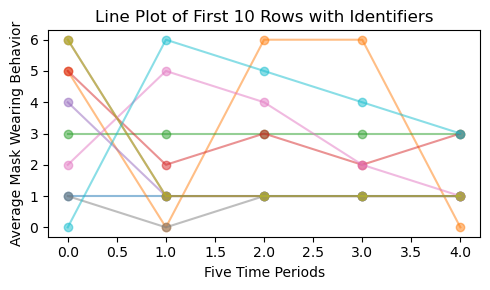

In [12]:
plt.figure(figsize=(5, 3))
subset_df = df.head(10)

for index, row in subset_df.iterrows():
    plt.plot(row['mask_averages'], marker='o', linestyle='-', label=f'Row {index}',alpha=0.5)
    # for i, value in enumerate(row['averages']):
    #     plt.text(i, value, str(index), fontsize=8)

plt.title('Line Plot of First 10 Rows with Identifiers')
plt.xlabel('Five Time Periods')
plt.ylabel('Average Mask Wearing Behavior')
# plt.legend(title="Row Identifiers", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

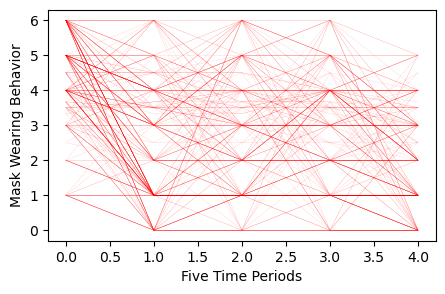

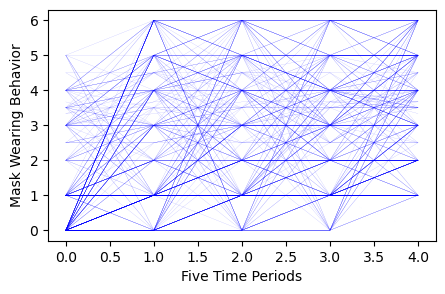

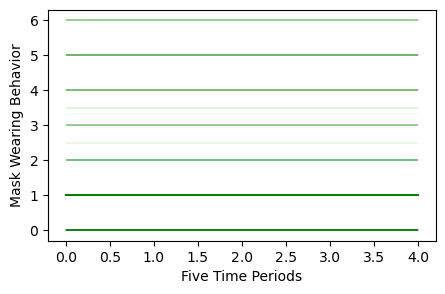

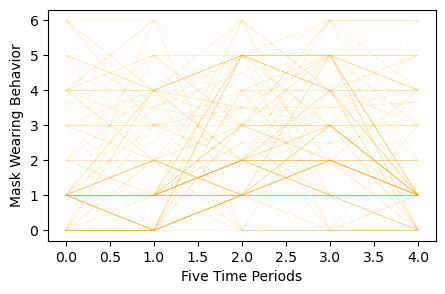

In [13]:
# Apply the function to the 'averages' column to create a new 'color' column
df['mask_color'] = df['mask_averages'].apply(determine_color)
colors = ['red', 'blue', 'green','orange']
for color in colors:
    df_filtered = df[df['mask_color'] == color]
    
    plt.figure(figsize=(5, 3))
    for index, row in df_filtered.iterrows():
        plt.plot(row['mask_averages'],lw = 0.1, linestyle='-', label=f'Row {index}', alpha=0.5, color=color)
    
    # plt.title(f'Lines for Rows with {color.upper()} Color')
    plt.xlabel('Five Time Periods')
    plt.ylabel('Mask Wearing Behavior')
    # Commenting out the legend to avoid clutter
    # plt.legend(title="Row Identifiers", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [14]:
color_counts = df['mask_color'].value_counts()

color_counts

mask_color
green     505
blue      369
red       282
orange    188
Name: count, dtype: int64

## Indoor

In [15]:
df['indoor_spring2020'].unique()

array(['Never', 'Rarely, when it could not be avoided',
       'Multiple times each week', 'Once or twice a month', 'Weekly',
       'The same as before the pandemic'], dtype=object)

In [16]:
replacement_dict_indoor = {
    "Never": 0,
    "The same as before the pandemic": 5,
    "Multiple times each week": 4,
    "Weekly": 3,
    "Once or twice a month": 2,
    "Rarely, when it could not be avoided": 1
}

In [17]:
indoor_cols = ['indoor_march2020',
       'indoor_spring2020', 'indoor_summer2020', 'indoor_fall2020',
       'indoor_winter2020']
indoor_cols_num = [f"{column}_num" for column  in indoor_cols]

for column in indoor_cols:
    new_col_name = f"{column}_num"  # Creates a new column name by appending '_num' to the original column name
    df[new_col_name] = df[column].apply(lambda x: replacement_dict_indoor.get(x) )

# # Apply the function to each cell in the selected columns and create a new column for the averages
# for column in indoor_cols:
#     new_col_name = f"{column}_num" 
#     df[new_col_name + '_avg'] = df[new_col_name].apply(calculate_average)

df['indoor_averages'] = df[[col + '_num' for col in indoor_cols]].values.tolist()

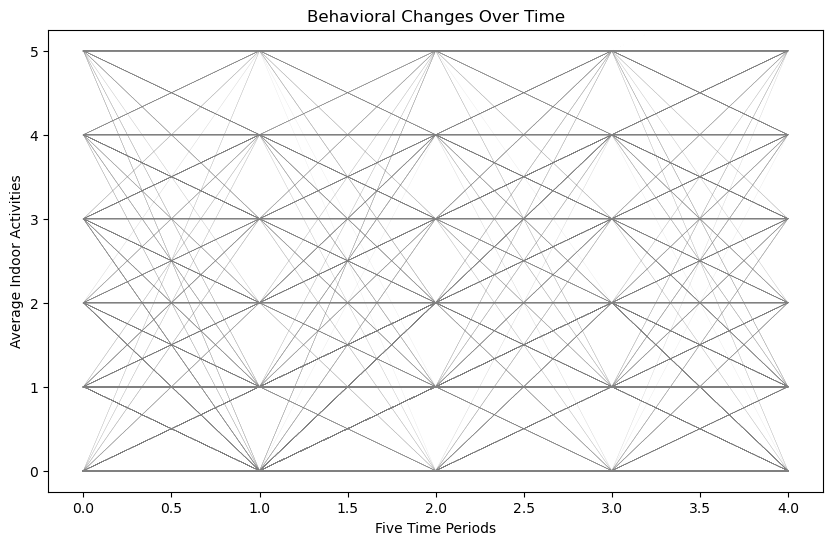

In [18]:
plt.figure(figsize=(10, 6))

# For each row in the dataframe, plot the 5 elements as a line
for index, row in df.iterrows():
    plt.plot(row['indoor_averages'], linestyle='-', alpha=0.5,lw='0.1',color='grey')  # Adjust alpha for better visualization

plt.title('Behavioral Changes Over Time')
plt.xlabel('Five Time Periods')
plt.ylabel('Average Indoor Activities')
plt.show()

0
1
2
3
4
5
6
7
8
9


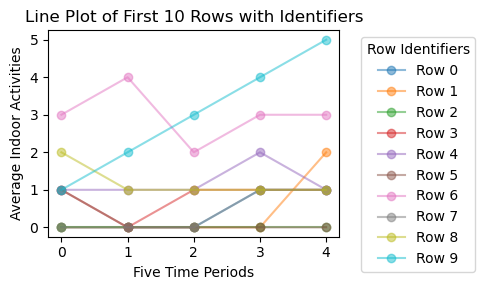

In [19]:
plt.figure(figsize=(5, 3))
subset_df = df.head(10)

for index, row in subset_df.iterrows():
    print(index)
    plt.plot(row['indoor_averages'], marker='o', linestyle='-', label=f'Row {index}',alpha=0.5)

plt.title('Line Plot of First 10 Rows with Identifiers')
plt.xlabel('Five Time Periods')
plt.ylabel('Average Indoor Activities')
plt.legend(title="Row Identifiers", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

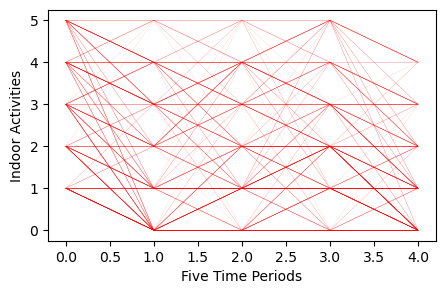

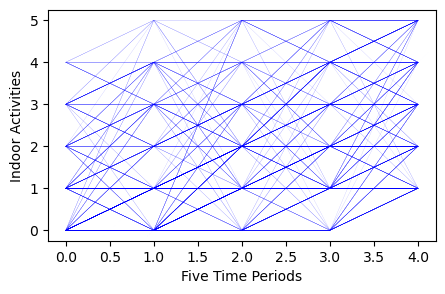

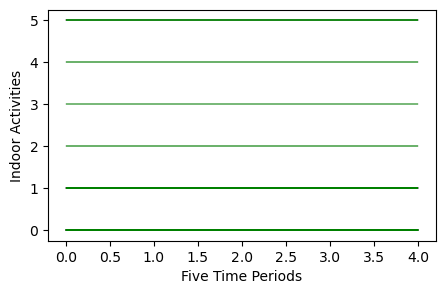

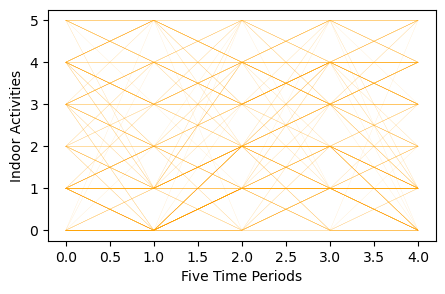

In [20]:
# Apply the function to the 'averages' column to create a new 'color' column
df['indoor_color'] = df['indoor_averages'].apply(determine_color)
colors = ['red', 'blue', 'green','orange']
for color in colors:
    df_filtered = df[df['indoor_color'] == color]
    
    plt.figure(figsize=(5, 3))
    for index, row in df_filtered.iterrows():
        plt.plot(row['indoor_averages'],lw = 0.1, linestyle='-', label=f'Row {index}', alpha=0.5, color=color)
    
    # plt.title(f'Lines for Rows with {color.upper()} Color')
    plt.xlabel('Five Time Periods')
    plt.ylabel('Indoor Activities')
    # Commenting out the legend to avoid clutter
    # plt.legend(title="Row Identifiers", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [21]:
color_counts = df['indoor_color'].value_counts()

color_counts

indoor_color
blue      426
green     402
red       275
orange    241
Name: count, dtype: int64

In [22]:
df.to_csv('../results/temp/behaviours_changes.csv',index=False)

In [23]:
df_grouped = df.groupby('MODZCTA')[indoor_cols_num].mean().reset_index()

In [24]:
mod_select = df_score_perinfo[df_score_perinfo['modzcta_count']>=15]['MODZCTA'].unique()
df_grouped_selected = df_grouped[df_grouped['MODZCTA'].isin(mod_select)]

In [28]:
df_grouped_selected['indoor_averages'] = df_grouped_selected[[col + '_num' for col in indoor_cols]].values.tolist()

/var/folders/_0/2l3z2qss74scb88wvbv1szxr0000gn/T/ipykernel_47064/177828247.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grouped_selected['indoor_averages'] = df_grouped_selected[[col + '_num' for col in indoor_cols]].values.tolist()


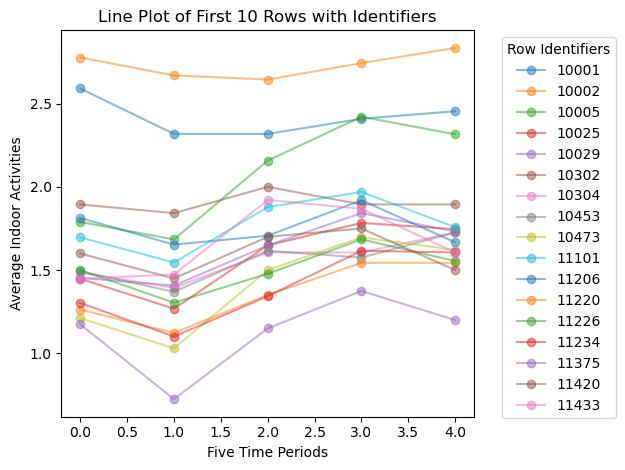

In [32]:
for index, row in df_grouped_selected.iterrows():
    # print(index)
    plt.plot(row['indoor_averages'], marker='o', linestyle='-', label=row['MODZCTA'],alpha=0.5)

plt.title('Line Plot of First 10 Rows with Identifiers')
plt.xlabel('Five Time Periods')
plt.ylabel('Average Indoor Activities')
plt.legend(title="Row Identifiers", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

In [49]:
import time
import warnings
from itertools import cycle, islice

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

ids = df['MODZCTA']
pattern_col = ['indoor_march2020_num',
       'indoor_spring2020_num_avg', 'indoor_summer2020_num_avg',
       'indoor_fall2020_num_avg', 'indoor_winter2020_num_avg']
data_to_scale = df_grouped_selected[indoor_cols_num]
# Apply scaling to the data without the ID
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_to_scale)

In [62]:
# Apply DBSCAN
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(data_scaled)
cluster_labels = kmeans.labels_

df_grouped_selected['k_mean_cluster'] = cluster_labels

/opt/anaconda3/envs/geo/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/_0/2l3z2qss74scb88wvbv1szxr0000gn/T/ipykernel_46852/3911600529.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grouped_selected['k_mean_cluster'] = cluster_labels


In [64]:
df_grouped_selected_sorted = df_grouped_selected.sort_values(by='k_mean_cluster')

In [65]:
df_grouped_selected_sorted.set_index('MODZCTA',inplace=True)

<Axes: ylabel='MODZCTA'>

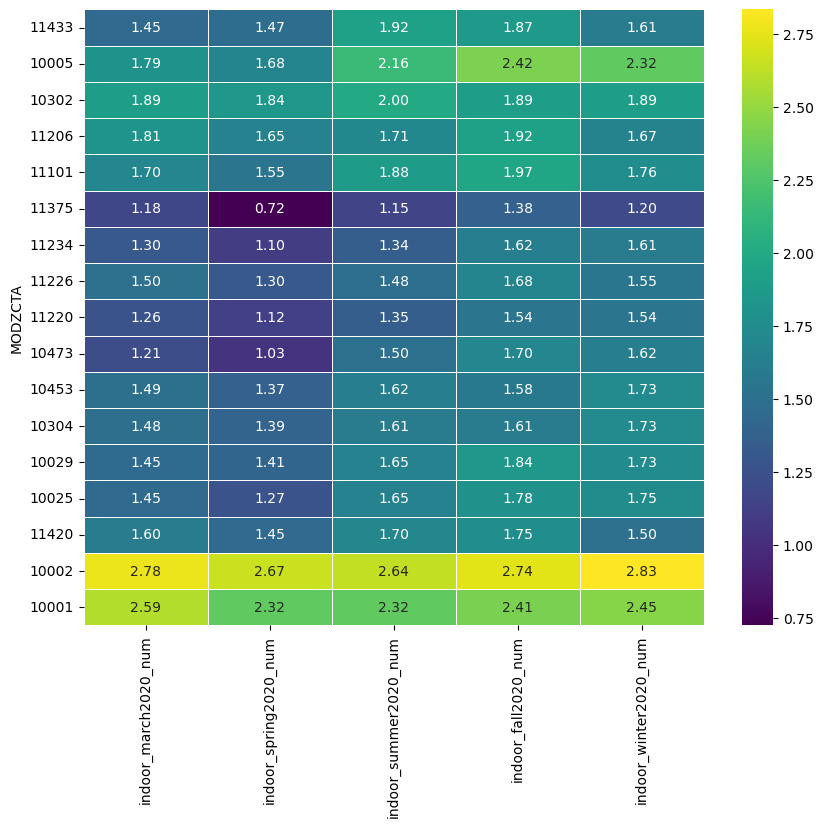

In [66]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(df_grouped_selected_sorted[indoor_cols_num], annot=True, cmap='viridis', cbar=True, fmt=".2f", linewidths=0.5)

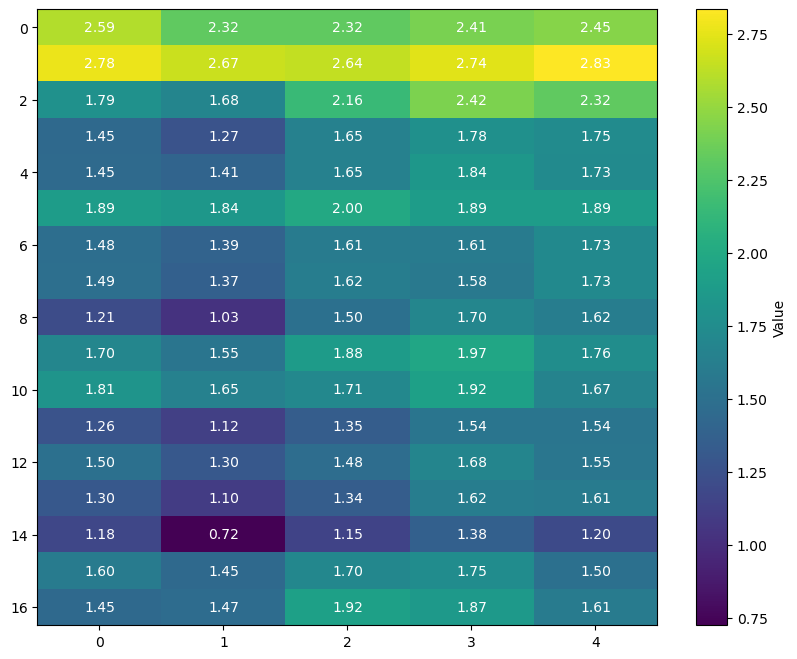

In [37]:
plt.figure(figsize=(10, 8))
plt.imshow(df_grouped_selected[indoor_cols_num], cmap='viridis', aspect='auto')

# Adding color bar
plt.colorbar(label="Value")

# Adding labels for each cell
for i in range(df_grouped_selected[indoor_cols_num].shape[0]):
    for j in range(df_grouped_selected[indoor_cols_num].shape[1]):
        plt.text(j, i, f"{df_grouped_selected[indoor_cols_num].iloc[i, j]:.2f}", ha='center', va='center', color="white")